In [3]:
import pandas as pd
import numpy as np

users = pd.read_csv('users_master.csv')
events = pd.read_csv('product_events.csv')
appts = pd.read_csv('appointments_by_user.csv')

In [4]:
sessions_attended = appts[appts['attended_flag'] == 1].groupby('user_id').size().reset_index(name='sessions_attended')
sessions_attended['is_retained'] = sessions_attended['sessions_attended'] >= 6
users_with_retention = users.merge(sessions_attended[['user_id', 'is_retained']], on='user_id', how='left')
users_with_retention['is_retained'] = users_with_retention['is_retained'].fillna(False)
users_with_retention.head()

/tmp/ipython-input-962849028.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users_with_retention['is_retained'] = users_with_retention['is_retained'].fillna(False)


,user_id,age,state,payer_type,risk_band,segment,cohort_week_start,is_retained
0,U0001,17,NY,Commercial,low,stable,2025-06-08,True
1,U0002,19,NY,Self-Pay,medium,at_risk_early,2025-06-22,False
2,U0003,16,FL,Commercial,low,stable,2025-07-20,True
3,U0004,20,NJ,Self-Pay,low,stable,2025-06-29,True
4,U0005,22,NY,Medicaid,medium,at_risk_early,2025-07-13,False


In [5]:
events_filtered = events[(events['weeks_since_first_session'] == 0) & (events['event_type'] != 'reminder_ack')]
event_types_to_check = ['post_visit_recap', 'homework_completed', 'community_thumbsup']
user_event_indicators = pd.DataFrame({'user_id': users_with_retention['user_id'].unique()})

for event_type in event_types_to_check:
    # Filter events_filtered for the current event_type
    users_with_event = events_filtered[events_filtered['event_type'] == event_type]['user_id'].unique()

    # Create a new binary column in user_event_indicators
    column_name = f'had_{event_type}'
    user_event_indicators[column_name] = user_event_indicators['user_id'].isin(users_with_event)

user_modeling = users_with_retention.merge(user_event_indicators, on='user_id' ,how='left')
user_modeling.head()

,user_id,age,state,payer_type,risk_band,segment,cohort_week_start,is_retained,had_post_visit_recap,had_homework_completed,had_community_thumbsup
0,U0001,17,NY,Commercial,low,stable,2025-06-08,True,True,False,False
1,U0002,19,NY,Self-Pay,medium,at_risk_early,2025-06-22,False,False,False,False
2,U0003,16,FL,Commercial,low,stable,2025-07-20,True,True,False,True
3,U0004,20,NJ,Self-Pay,low,stable,2025-06-29,True,False,True,False
4,U0005,22,NY,Medicaid,medium,at_risk_early,2025-07-13,False,False,False,False


In [6]:
from sklearn.model_selection import train_test_split

# Re-defining feature_list and target as they were not defined in the current execution environment
feature_list = ['age', 'state', 'payer_type', 'risk_band', 'had_post_visit_recap', 'had_homework_completed', 'had_community_thumbsup']
target = 'is_retained'

# 1. Separate features (X) and target (y)
X = user_modeling[feature_list]
y = user_modeling[target]

# Identify categorical columns for one-hot encoding
categorical_features = X.select_dtypes(include=['object', 'bool']).columns

# 2. Apply one-hot encoding to categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# 3. Split the processed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



--- Training Set Performance ---
Classification Report (Training Set):
              precision    recall  f1-score   support

       False       0.90      0.21      0.34       131
        True       0.80      0.99      0.89       429

    accuracy                           0.81       560
   macro avg       0.85      0.60      0.61       560
weighted avg       0.83      0.81      0.76       560

Confusion Matrix (Training Set):


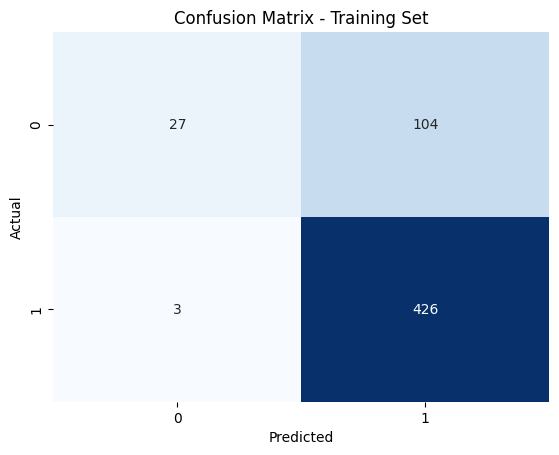


--- Test Set Performance ---
Classification Report (Test Set):
              precision    recall  f1-score   support

       False       0.40      0.13      0.20        30
        True       0.80      0.95      0.87       110

    accuracy                           0.77       140
   macro avg       0.60      0.54      0.53       140
weighted avg       0.71      0.77      0.72       140

Confusion Matrix (Test Set):


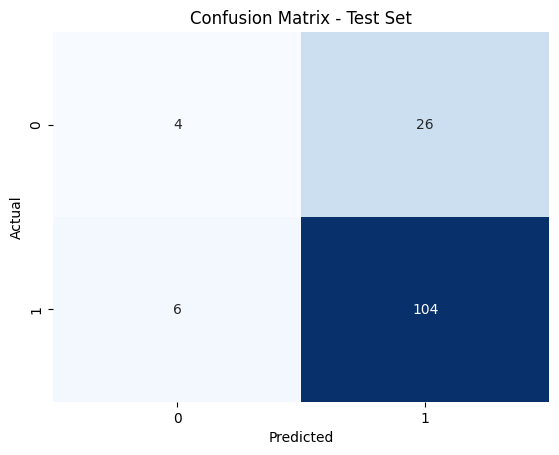

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state=42, max_depth=7, min_samples_leaf=2)
model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Evaluate training set performance
print("\n--- Training Set Performance ---")
print("Classification Report (Training Set):")
print(classification_report(y_train, y_train_pred))

print("Confusion Matrix (Training Set):")
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Evaluate test set performance
print("\n--- Test Set Performance ---")
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test Set):")
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

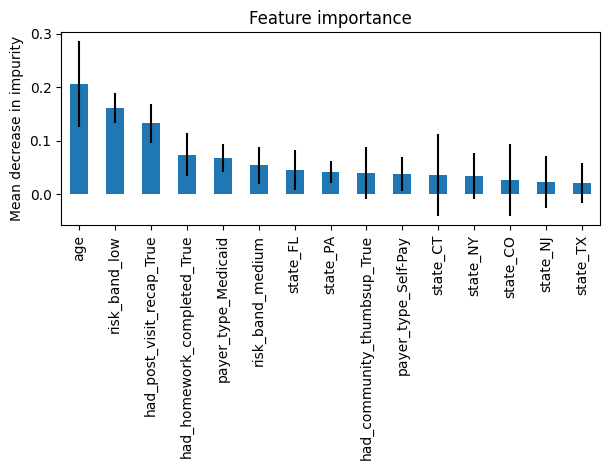

In [11]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')